In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [40]:
df = pd.read_csv('../dataset/rumah123_jabodetabek.csv')

In [41]:
df.sample(5, random_state=16) # initial dataset

,location,sub_district,title,price,lt,lb
10101,jakarta-utara,tanjung-priok,Dijual Kontrakan 10 Pintu Bebas Banjir Daerah ...,"Rp 1,9 Miliar",194 m²,350 m²
32194,jakarta-barat,kalideres,RUMAH MINIMALIS 2 LANTAI FULL SIAP HUNI DI CIT...,"Rp 1,9 Miliar",90 m²,144 m²
37218,bogor,ciawi,Rumah View Gunung Pancar Kawasan Taman Wisata ...,Rp 950 Juta,72 m²,45 m²
63727,tangerang,larangan,Rumah Baru Siap Huni Model Elegant Larangan Ta...,"Rp 2,85 Miliar",280 m²,304 m²
40244,bogor,cisarua,Dijual Rumah Dengan Pemandangan Gunung Di Cisa...,"Rp 14,9 Miliar",8430 m²,1565 m²


## Cleaning

### Remove Duplicate Values

In [42]:
df = df.drop_duplicates()

### Remove Rows with Null Values

In [43]:
df.isna().sum()

location          0
sub_district      0
title             3
price             0
lt               55
lb              390
dtype: int64

In [44]:
df = df.dropna()

In [45]:
df.isna().sum()

location        0
sub_district    0
title           0
price           0
lt              0
lb              0
dtype: int64

### Change Location and Sub District Formatting

#### Replace '-' with blank space (' ')

In [46]:
df['sub_district'] = df['sub_district'].str.replace('-', ' ')
df['location'] = df['location'].str.replace('-', ' ')

#### Capitalize Each Word

In [47]:
df['sub_district'] = df['sub_district'].str.title()
df['location'] = df['location'].str.title()

### Convert price from 'rupiah terbilang' to float

In [48]:
df['price_wording'] = df['price']

df['price'] = df['price'].str.replace('Rp ', '')
df['price'] = df['price'].str.replace('Hubungi', '')
df['price'] = df['price'].str.replace(',', '.')

df[['price', 'price_unit']] = df['price'].str.split(' ', expand=True)
df = df[df['price_unit'] != 'Agen']

In [49]:
df['price'] = df['price'].astype(float)

def multiply_price(row: float):
    if row['price_unit'] == 'Miliar':
        return row['price'] * 1_000_000_000
    elif row['price_unit'] == 'Juta':
        return row['price'] * 1_000_000
    else:
        return row['price']

df['price'] = df.apply(multiply_price, axis=1)

df = df.drop(columns=['price_unit'])

### Remove square root (m²) unit

In [50]:
df['lt'] = df['lt'].str.replace(' m²', '')
df['lb'] = df['lb'].str.replace(' m²', '')

df['lt'] = df['lt'].astype(float)
df['lb'] = df['lb'].astype(float)


### Filter Based on Domain Knowledge

#### Filter Only Values that LT and LB < 5000 meter squared

In [51]:
df = df[(df['lt'] < 5_000) & (df['lb'] < 5_000)]

#### Remove Rumah dengan Keyword Sewa

In [52]:
contain_sewa = df[(df['title'].str.contains('sewa'))]
contain_sewa = contain_sewa[df['price'] < 250_000_000]

df = df.drop(contain_sewa.index)

/var/folders/z0/kx9y6yvj26l1d5lf5zb9pmjr0000gn/T/ipykernel_27119/543893186.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  contain_sewa = contain_sewa[df['price'] < 250_000_000]


#### Remove Rumah dengan Harga di Bawah 100.000.000

In [53]:
df = df[df['price'] >= 100_000_000]

#### Make Absolute Value of Non-negative Numeric Value

In [54]:
df['lb'] = df['lb'].abs()

## EDA

### Sample After Cleaning

In [55]:
df.sample(5, random_state=16)

,location,sub_district,title,price,lt,lb,price_wording
79394,Tangerang Selatan,Pondok Aren,Rumah mewah modern murah dengan kolam renang l...,14000000000.0,500.0,263.0,Rp 14 Miliar
11556,Jakarta Timur,Cakung,Dijual Rumah Asya Cluster Matana Cakung Jakart...,2900000000.0,98.0,134.0,"Rp 2,9 Miliar"
8598,Jakarta Utara,Pademangan,"Rumah Semi Brand New 3 Lantai di Pademangan, J...",1650000000.0,70.0,150.0,"Rp 1,65 Miliar"
97476,Bekasi,Tarumajaya,"Rumah Baru di Wahana Harapan , Bekasi K1119",385000000.0,60.0,50.0,Rp 385 Juta
14661,Jakarta Timur,Duren Sawit,Rumah Non Cluster Siap Huni Dijual di Duren Sa...,3750000000.0,135.0,190.0,"Rp 3,75 Miliar"


### Basic Statistic

In [56]:
df.describe()

,price,lt,lb
count,86475.0,86475.0,86475.0
mean,4516182017.9,213.1,192.7
std,16370130274.3,344.2,241.3
min,100000000.0,1.0,1.0
25%,750000000.0,72.0,62.0
50%,1550000000.0,108.0,120.0
75%,3600000000.0,206.0,230.0
max,995000000000.0,4969.0,4701.0


### Distribusi Kecamatan

<Axes: title={'center': 'Distribusi Banyak Instance Tiap Kecamatan'}, ylabel='Frequency'>

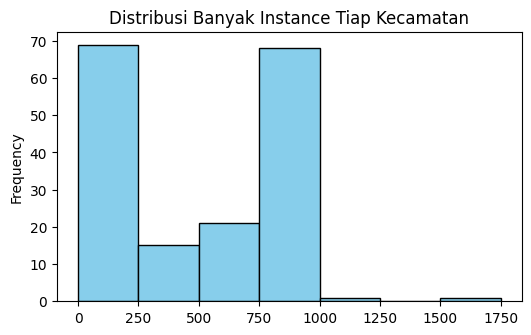

In [57]:
count_kecamatan = df['sub_district'].value_counts()

plt.figure(figsize=(6, 3.5))
plt.title('Distribusi Banyak Instance Tiap Kecamatan')
plt.xlabel('Jumlah Kecamatan')
# show numbers over the bar
count_kecamatan.plot(kind='hist', bins=np.arange(0, 2000, 250), color='skyblue', edgecolor='black')

## Analysis

### Derived Price/Lt and Price/Lb

In [58]:
df['price_per_lt'] = df['price'] / df['lt']
df['price_per_lb'] = df['price'] / df['lb']

In [59]:
df = df[['location', 'sub_district', 'title', 'price', 'price_wording', 'lt', 'price_per_lt', 'lb', 'price_per_lb']]
df.sample(5, random_state=16)

,location,sub_district,title,price,price_wording,lt,price_per_lt,lb,price_per_lb
79394,Tangerang Selatan,Pondok Aren,Rumah mewah modern murah dengan kolam renang l...,14000000000.0,Rp 14 Miliar,500.0,28000000.0,263.0,53231939.2
11556,Jakarta Timur,Cakung,Dijual Rumah Asya Cluster Matana Cakung Jakart...,2900000000.0,"Rp 2,9 Miliar",98.0,29591836.7,134.0,21641791.0
8598,Jakarta Utara,Pademangan,"Rumah Semi Brand New 3 Lantai di Pademangan, J...",1650000000.0,"Rp 1,65 Miliar",70.0,23571428.6,150.0,11000000.0
97476,Bekasi,Tarumajaya,"Rumah Baru di Wahana Harapan , Bekasi K1119",385000000.0,Rp 385 Juta,60.0,6416666.7,50.0,7700000.0
14661,Jakarta Timur,Duren Sawit,Rumah Non Cluster Siap Huni Dijual di Duren Sa...,3750000000.0,"Rp 3,75 Miliar",135.0,27777777.8,190.0,19736842.1


### Aggregate by Kecamatan

#### by Price

In [60]:
df_aggregate_price = df.groupby('sub_district').agg({'price': ['mean', 'median', 'std', 'min', 'max', 'count']})
df_aggregate_price = df_aggregate_price.sort_values(by=('price', 'mean'), ascending=False)
df_aggregate_price

price                                          \
                        mean        median           std         min   
sub_district                                                           
Menteng        62895802363.1 50000000000.0 59326966685.8 492000000.0   
Kebayoran Baru 32377743644.1 21750000000.0 35004960549.8 170000000.0   
Setiabudi      16207853121.2 12000000000.0 16678994896.3 265000000.0   
Tanah Abang    14532676731.8 12000000000.0 16495804175.7 115000000.0   
Kebayoran Lama 14040023307.4  8700000000.0 18206379908.0 200000000.0   
...                      ...           ...           ...         ...   
Jasinga          284500000.0   310000000.0    86338481.2 168000000.0   
Leuwisadeng      261666666.7   300000000.0    66395281.0 185000000.0   
Solear           229714285.7   185000000.0   123225514.7 115000000.0   
Cisoka           219722222.2   181000000.0   107257130.6 125000000.0   
Jayanti          182555555.6   178000000.0    10393641.2 178000000.0   

                                     
                          max count  
sub_district                         
Menteng        550000000000.0   931  
Kebayoran Baru 296000000000.0   944  
Setiabudi      140000000000.0   817  
Tanah Abang    105000000000.0   563  
Kebayoran Lama 250000000000.0   901  
...                       ...   ...  
Jasinga           350000000.0     4  
Leuwisadeng       300000000.0     3  
Solear            540000000.0    14  
Cisoka            671000000.0    36  
Jayanti           210000000.0     9  

[175 rows x 6 columns]

In [61]:
ordered_list_price = df_aggregate_price['price']['mean'].keys().tolist()
ordered_list_price[:5]

['Menteng', 'Kebayoran Baru', 'Setiabudi', 'Tanah Abang', 'Kebayoran Lama']

#### by Price / LT

In [62]:
df_aggregate_price_lt  = df.groupby('sub_district').agg({'price_per_lt': ['mean', 'median', 'std', 'min', 'max', 'count']})
df_aggregate_price_lt = df_aggregate_price_lt.sort_values(by=('price_per_lt', 'mean'), ascending=False)
df_aggregate_price_lt

price_per_lt                                    \
                         mean     median          std       min   
sub_district                                                      
Cikarang Selatan  308912300.4  8403361.3 7732077223.9 1310861.4   
Menteng           240079820.9 75000000.0 4913610925.6 9840000.0   
Palmerah          168273183.6 27403556.4 2639641817.0 2766666.7   
Mampang Prapatan  129876826.1 26729559.7 2011823298.2 3071253.1   
Pancoran          103706745.0 26737967.9 1337012714.9  566037.7   
...                       ...        ...          ...       ...   
Kronjo              2466029.2  2466029.2     640559.7 2013085.1   
Leuwisadeng         2462560.4  3000000.0    1003906.6 1304347.8   
Cigudeg             1956116.7  1956116.7    1847127.9  650000.0   
Tenjolaya           1814886.4  1663606.8    1050630.2  761904.8   
Cidaun              1621621.6  1621621.6          NaN 1621621.6   

                                       
                            max count  
sub_district                           
Cikarang Selatan 200000000000.0   669  
Menteng          150000000000.0   931  
Palmerah          60000000000.0   562  
Mampang Prapatan  45000000000.0   840  
Pancoran          31500000000.0   839  
...                         ...   ...  
Kronjo                2918973.3     2  
Leuwisadeng           3083333.3     3  
Cigudeg               3262233.4     2  
Tenjolaya             3711790.4     6  
Cidaun                1621621.6     1  

[175 rows x 6 columns]

In [63]:
ordered_list_price_lt = df_aggregate_price_lt['price_per_lt']['mean'].keys().tolist()
ordered_list_price_lt[:5]

['Cikarang Selatan', 'Menteng', 'Palmerah', 'Mampang Prapatan', 'Pancoran']

#### by Price / LB

In [64]:
df_aggregate_price_lb = df.groupby('sub_district').agg({'price_per_lb': ['mean', 'median', 'std', 'min', 'max', 'count']})
df_aggregate_price_lb = df_aggregate_price_lb.sort_values(by=('price_per_lb', 'mean'), ascending=False)
df_aggregate_price_lb

price_per_lb                                    \
                         mean     median          std       min   
sub_district                                                      
Menteng           445246327.4 77647058.8 5954090573.5 7809523.8   
Kebayoran Baru    319554783.7 55857142.9 5471640284.6 2827140.5   
Cikarang Selatan  310926867.9 10964912.3 7731986067.9 1888888.9   
Periuk            135663339.2 10000000.0 1467960860.4 1777777.8   
Palmerah          133344106.3 17500000.0 2530705778.0 2328676.0   
...                       ...        ...          ...       ...   
Solear              5140740.7  5236111.1    1558095.2 2600000.0   
Mande               5006630.4  4500000.0    2217605.1 1652892.6   
Leuwisadeng         4305555.6  3750000.0    1654819.0 3000000.0   
Kronjo              3500000.0  3500000.0     909137.3 2857142.9   
Cibeber             2568627.5  2568627.5     804160.7 2000000.0   

                                       
                            max count  
sub_district                           
Menteng          150000000000.0   931  
Kebayoran Baru   119000000000.0   944  
Cikarang Selatan 200000000000.0   669  
Periuk            20833333333.3   225  
Palmerah          60000000000.0   562  
...                         ...   ...  
Solear                7500000.0    14  
Mande                 8166666.7     9  
Leuwisadeng           6166666.7     3  
Kronjo                4142857.1     2  
Cibeber               3137254.9     2  

[175 rows x 6 columns]

In [65]:
ordered_list_price_lb = df_aggregate_price_lb['price_per_lb']['mean'].keys().tolist()
ordered_list_price_lb[:5]

['Menteng', 'Kebayoran Baru', 'Cikarang Selatan', 'Periuk', 'Palmerah']

### Aggregate by Kota

#### by Price

In [66]:
df_aggregate_price_city = df.groupby('location').agg({'price': ['mean', 'median', 'std', 'min', 'max', 'count']})
df_aggregate_price_city = df_aggregate_price_city.sort_values(by=('price', 'mean'), ascending=False)
df_aggregate_price_city

price                                          \
                           mean       median           std          min   
location                                                                  
Jakarta Pusat     18470128579.7 6800000000.0 35284058857.9  115000000.0   
Jakarta Selatan   12412402876.1 7100000000.0 17550239364.9  150000000.0   
Kepulauan Seribu   6500000000.0 6500000000.0           0.0 6500000000.0   
Jakarta Barat      5348895621.6 3500000000.0  6447713161.6  110000000.0   
Jakarta Utara      4840626656.8 2750000000.0  9020664543.3  237000000.0   
Jakarta Timur      4218112700.4 2600000000.0 14180228759.8  100000000.0   
Tangerang Selatan  2395698401.8 1570000000.0  8166197859.1  111000000.0   
Tangerang          2285130501.0 1350000000.0 15820006942.2  100000000.0   
Cianjur            1915884510.9  889500000.0  2916643353.8  125000000.0   
Depok              1817265745.3  900000000.0 12927369397.8  100000000.0   
Bogor              1722536953.2  775000000.0 11628658620.4  100000000.0   
Bekasi             1530537469.1  800000000.0 14472739740.4  100000000.0   

                                         
                             max  count  
location                                 
Jakarta Pusat     550000000000.0   5203  
Jakarta Selatan   296000000000.0   9040  
Kepulauan Seribu    6500000000.0      2  
Jakarta Barat      85000000000.0   5116  
Jakarta Utara     400000000000.0   4074  
Jakarta Timur     840000000000.0   6362  
Tangerang Selatan 595000000000.0   5819  
Tangerang         850000000000.0  14452  
Cianjur            25000000000.0    736  
Depok             875000000000.0  10130  
Bogor             950000000000.0  12597  
Bekasi            995000000000.0  12944

#

In [67]:
ordered_list_price_city = df_aggregate_price_city['price']['mean'].keys().tolist()
ordered_list_price_city[:5]

['Jakarta Pusat',
 'Jakarta Selatan',
 'Kepulauan Seribu',
 'Jakarta Barat',
 'Jakarta Utara']

#### by Price / LT

In [68]:
df_aggregate_price_lt_city  = df.groupby('location').agg({'price_per_lt': ['mean', 'median', 'std', 'min', 'max', 'count']})
df_aggregate_price_lt_city = df_aggregate_price_lt_city.sort_values(by=('price_per_lt', 'mean'), ascending=False)
df_aggregate_price_lt_city

price_per_lt                                     \
                          mean     median          std        min   
location                                                            
Jakarta Pusat       69925431.4 29411764.7 2080485671.5   552000.0   
Jakarta Selatan     55960778.8 26577324.8  929605747.2   566037.7   
Jakarta Barat       44165068.5 23498697.8  894699469.5   694444.4   
Bekasi              28515245.4  8750000.0 1765500275.5   200000.0   
Jakarta Utara       28224606.4 24705882.4  102851892.3  1034482.8   
Kepulauan Seribu    26000000.0 26000000.0          0.0 26000000.0   
Jakarta Timur       24465166.2 17736216.0  217365981.1  1282051.3   
Tangerang           21162871.0 12738095.2  260943657.3   578034.7   
Tangerang Selatan   16681808.8 13750000.0  130126409.2  1541666.7   
Depok               16068447.0 10666666.7  195934225.4   932504.4   
Bogor               12646962.5  7444444.4  188419524.5   387755.1   
Cianjur              4518581.0  3500000.0    4620138.4   228494.6   

                                         
                             max  count  
location                                 
Jakarta Pusat     150000000000.0   5203  
Jakarta Selatan    52000000000.0   9040  
Jakarta Barat      60000000000.0   5116  
Bekasi            200000000000.0  12944  
Jakarta Utara       6153846153.8   4074  
Kepulauan Seribu      26000000.0      2  
Jakarta Timur      11200000000.0   6362  
Tangerang          18974358974.4  14452  
Tangerang Selatan   9916666666.7   5819  
Depok              13674418604.7  10130  
Bogor              14179104477.6  12597  
Cianjur               71428571.4    736

In [69]:
ordered_list_price_lt_city = df_aggregate_price_lt_city['price_per_lt']['mean'].keys().tolist()
ordered_list_price_lt_city[:5]

['Jakarta Pusat',
 'Jakarta Selatan',
 'Jakarta Barat',
 'Bekasi',
 'Jakarta Utara']

#### by Price / LB

In [70]:
df_aggregate_price_lb_city  = df.groupby('location').agg({'price_per_lb': ['mean', 'median', 'std', 'min', 'max', 'count']})
df_aggregate_price_lb_city = df_aggregate_price_lb_city.sort_values(by=('price_per_lb', 'mean'), ascending=False)
df_aggregate_price_lb_city

price_per_lb                                     \
                          mean     median          std        min   
location                                                            
Jakarta Pusat      111455785.6 24418604.7 2542425386.5  1320000.0   
Jakarta Selatan     80977602.3 24038461.5 1927629384.5   633333.3   
Jakarta Utara       51881630.0 16666666.7  505240520.2  1046153.8   
Jakarta Barat       35663281.3 16915644.7  847232998.1   419354.8   
Bekasi              31083450.3 10818181.8 1774292240.5   272547.1   
Tangerang           24716290.0 13386296.8  396007513.2   383047.2   
Jakarta Timur       24549022.2 15333333.3  246726578.2   130046.9   
Tangerang Selatan   18292556.8 14285714.3  194968189.5   814132.1   
Depok               17708393.5 12142857.1  216353255.2   942029.0   
Bogor               17422834.6 11097222.2  225563999.3   231833.9   
Kepulauan Seribu    16250000.0 16250000.0          0.0 16250000.0   
Cianjur              7760949.6  6130553.9    7276229.2  1188235.3   

                                         
                             max  count  
location                                 
Jakarta Pusat     150000000000.0   5203  
Jakarta Selatan   119000000000.0   9040  
Jakarta Utara      15000000000.0   4074  
Jakarta Barat      60000000000.0   5116  
Bekasi            200000000000.0  12944  
Tangerang          30000000000.0  14452  
Jakarta Timur      12923076923.1   6362  
Tangerang Selatan  14875000000.0   5819  
Depok              14000000000.0  10130  
Bogor              13194444444.4  12597  
Kepulauan Seribu      16250000.0      2  
Cianjur               80400000.0    736

In [71]:
ordered_list_price_lb_city = df_aggregate_price_lb_city['price_per_lb']['mean'].keys().tolist()
ordered_list_price_lb_city[:5]

['Jakarta Pusat',
 'Jakarta Selatan',
 'Jakarta Utara',
 'Jakarta Barat',
 'Bekasi']